# Torch Notes for Transformer and Related Materials

In [2]:
# As before, we need to include some libraries
import torch
from torch import nn
import math
import myutils
import pandas as pd

In [3]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
#  A colab link for attention visualization
#  https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb#scrollTo=OJKU36QAfqOC

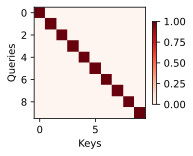

In [4]:
# Some visualizations of attention
# Identity weight

attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
myutils.show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

In [5]:
# functionality of masked softmax
# Check what masked softmax do?
myutils.masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4538, 0.5462, 0.0000, 0.0000],
         [0.4829, 0.5171, 0.0000, 0.0000]],

        [[0.3702, 0.3026, 0.3272, 0.0000],
         [0.2644, 0.4502, 0.2854, 0.0000]]])

In [17]:
# ---------------------------------
# additive attention
# ---------------------------------
# a(q,k) = w_v tanh(W_q q + W_k k)
# pay attention to tensor operation.

class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        # 线性层默认都是对输入样本的最后一个维度操作
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使⽤⼴播⽅式进⾏求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # print(features.shape)
        features = torch.tanh(features)
        # self.w_v仅有⼀个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = myutils.masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        # torch.bmm: https://blog.csdn.net/qq_43391414/article/details/110442229
        return torch.bmm(self.dropout(self.attention_weights), values)

In [151]:
# In the following cells, we test additive attention

# check the sizes of your query and key 
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# batch size是2，有一个查询，查询的维度是20；
# 有10个原本的key（“键－值”对的个数为10），每个key的维度是2
queries.shape, keys.shape

(torch.Size([2, 1, 20]), torch.Size([2, 10, 2]))

In [152]:
# check the size of value
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
values.shape

torch.Size([2, 10, 4])

In [20]:
# 隐藏层神经元数量为8
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

In [22]:
attention.W_q(queries).shape, attention.W_q(queries).unsqueeze(2).shape

(torch.Size([2, 1, 8]), torch.Size([2, 1, 1, 8]))

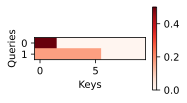

In [27]:
# heat map of attention values
myutils.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)), xlabel='Keys', ylabel='Queries')

In [160]:
# ---------------------
# dot attention
# ---------------------

class DotProductAttention(nn.Module):
    """缩放点积注意⼒"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=-1)
    # DotProductAttention要求每个queries和keys的长度相同
    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        # torch.bmm将每个输入的最后两个维度对应的矩阵对应相乘，得到数量等于第一维大小的结果，然后将结果拼接起来
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        # 如果不使用masked_softmax，使用简单的softmax，则和经典的点积注意力相同
        self.attention_weights = myutils.masked_softmax(scores, valid_lens)
        # 替换为这个也可以，对最后一个维度（即“键－值”对的个数这个维度做softmax）
        # self.attention_weights = self.softmax(scores)  
        return torch.bmm(self.dropout(self.attention_weights), values)

In [161]:
# In the following cells, we test dot attention

queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

In [73]:
self = attention
print(queries.shape, keys.shape, keys.transpose(1,2).shape, values.shape)
print('-' * 100)
d = queries.shape[-1]
scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
print(scores, scores.shape)
print('-' * 100)
self.attention_weights = myutils.masked_softmax(scores, valid_lens)
print(self.attention_weights, self.attention_weights.shape)
print('-' * 100)
print(self.dropout(self.attention_weights).shape, values.shape)
print(torch.bmm(self.dropout(self.attention_weights), values), 
      torch.bmm(self.dropout(self.attention_weights), values).shape)

torch.Size([2, 1, 2]) torch.Size([2, 10, 2]) torch.Size([2, 2, 10]) torch.Size([2, 10, 4])
----------------------------------------------------------------------------------------------------
tensor([[[2.2507, 2.2507, 2.2507, 2.2507, 2.2507, 2.2507, 2.2507, 2.2507,
          2.2507, 2.2507]],

        [[0.1801, 0.1801, 0.1801, 0.1801, 0.1801, 0.1801, 0.1801, 0.1801,
          0.1801, 0.1801]]]) torch.Size([2, 1, 10])
----------------------------------------------------------------------------------------------------
tensor([[[0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
          0.0000, 0.0000]]]) torch.Size([2, 1, 10])
----------------------------------------------------------------------------------------------------
torch.Size([2, 1, 10]) torch.Size([2, 10, 4])
tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]]) torc

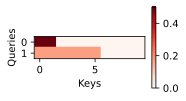

In [14]:
myutils.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
        xlabel='Keys', ylabel='Queries')

In [89]:
# ----------------------
# position encoding
# ----------------------
# write the encoding function from scratch

class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建⼀个⾜够⻓的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)  # 偶数列为sin
        self.P[:, :, 1::2] = torch.cos(X)  # 奇数列为cos
        
    def forward(self, X):
        # 这里相加运用了广播机制，对第一个维度（代表batch）进行广播相加
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

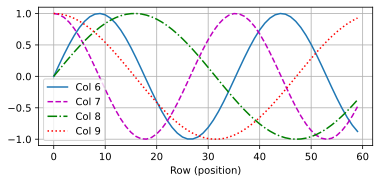

In [76]:
# Curve plot of position encoding values
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
# model.eval() 方法用于将模型设置为评估模式（evaluation mode）。
# 这在进行模型验证或测试时非常重要，因为它会影响模型中某些层（如 Batch Normalization 和 Dropout）的行为：
# 1. Batch Normalization：在训练模式下，Batch Normalization 层会使用当前批次的均值和方差进行归一化；
# 而在评估模式下，它会使用整个训练集的均值和方差。
# 2. Dropout：在训练模式下，Dropout 层会随机丢弃一部分神经元以防止过拟合；
# 而在评估模式下，Dropout 层会保持所有神经元的激活状态，不进行丢弃操作。
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
myutils.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
        figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

In [81]:
# X表示一个样本，其中包含60个词元（时间步长T=60），每个词元的嵌入表示都是32维的
print('输入X的形状：', torch.zeros((1, num_steps, encoding_dim)).shape)
print('P的形状：', P.shape)  # P的形状和X相同，最终位置编码嵌入后的结果就是X + P

输入X的形状： torch.Size([1, 60, 32])
P的形状： torch.Size([1, 60, 32])


In [88]:
self = pos_encoding
max_len = 1000
num_hiddens = encoding_dim
X = torch.arange(max_len, dtype=torch.float32).reshape(
    -1, 1) / torch.pow(10000, torch.arange(
    0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
print(X.shape, self.P.shape)

torch.Size([1000, 16]) torch.Size([1, 1000, 32])


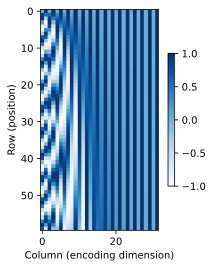

In [90]:
# Heatmap of position encoding values
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
myutils.show_heatmaps(P, xlabel='Column (encoding dimension)',
    ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

In [96]:
# --------------------------
# multi-head attention
# --------------------------

def transpose_qkv(X, num_heads):
    """为了多注意⼒头的并⾏计算⽽变换形状"""
    # 输⼊X的形状:(batch_size，查询或者“键－值”对的个数, num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数, num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    # 输出X的形状:(batch_size，num_heads, 查询或者“键－值”对的个数, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    # 最终输出的形状:(batch_size*num_heads, 查询或者“键－值”对的个数, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)


class MultiHeadAttention(nn.Module):
    """多头注意⼒"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
            num_heads, dropout, bias=False, **kwargs):
        # query_size代表每个query的长度，对应T * C中的C
        # key_size和value_size分别代表key和value的长度
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = myutils.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
        
    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values经过线性层W_q/W_k/W_v后的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens 的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values 的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        if valid_lens is not None:
            # 在轴0，将第⼀项（标量或者⽮量）复制num_heads次，
            # 然后如此复制第⼆项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        
        # output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        
        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [109]:
# Create and attention instance
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [110]:
# Check the output size 
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 8, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, None).shape

torch.Size([2, 4, 100])

In [112]:
queries = X
keys = Y
values = Y
valid_lens = None
self = attention
# 原始输入的形状
print(queries.shape, self.W_q(queries).shape)
print(keys.shape, self.W_k(keys).shape)
print(values.shape, self.W_v(values).shape)

print('-' * 100)

queries = transpose_qkv(self.W_q(queries), self.num_heads)
keys = transpose_qkv(self.W_k(keys), self.num_heads)
values = transpose_qkv(self.W_v(values), self.num_heads)
print(queries.shape, keys.shape, values.shape)
print('-' * 100)
output = self.attention(queries, keys, values, valid_lens)
print(output.shape)

torch.Size([2, 4, 100]) torch.Size([2, 4, 100])
torch.Size([2, 8, 100]) torch.Size([2, 8, 100])
torch.Size([2, 8, 100]) torch.Size([2, 8, 100])
----------------------------------------------------------------------------------------------------
torch.Size([10, 4, 20]) torch.Size([10, 8, 20]) torch.Size([10, 8, 20])
----------------------------------------------------------------------------------------------------
torch.Size([10, 4, 20])


In [134]:
# (batch_size，查询或者“键－值”对的个数, num_hiddens)
# batch_size = 2, 查询个数 = 4，num_hidden = 10
# num_heads = 5
X1 = torch.normal(0, 1, (2, 4, 10))
print(X1)
print('-' * 100)
X2 = transpose_qkv(X1, num_heads)
# (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
print(X2.shape, X2)
print('-' * 100)
X3 = transpose_output(X2, num_heads)
print(X3.shape, X3)

tensor([[[ 0.5539,  1.0705, -0.2467, -0.5468, -1.7312, -2.0616,  0.3531,
          -0.4130,  1.0877, -0.5055],
         [-0.5932, -1.7048, -1.2851,  2.2417,  0.1598,  1.7439,  0.2931,
           0.5772, -0.9581,  0.0934],
         [-2.5355,  0.7530,  0.1360,  1.8002,  0.1014,  1.0509,  0.1189,
           0.1370,  2.0581,  0.5469],
         [-0.9428, -0.5843,  0.3410,  0.3342, -0.4662,  0.3798,  0.4280,
           0.1393,  0.8714,  0.8208]],

        [[-0.5270,  1.1127, -0.8002,  0.2327,  0.0092,  2.0392,  0.1956,
           0.4724,  0.5946,  0.7278],
         [ 0.8295,  0.6407,  0.8582,  0.0355,  0.8866,  0.4612, -0.6274,
          -0.7547, -2.3391, -0.6268],
         [ 0.6303, -0.8556, -0.5170,  0.2306,  2.2069,  1.0255, -1.3400,
          -1.7307,  1.8668, -0.6481],
         [ 0.6687,  0.5716, -0.0222,  0.2900,  0.4844,  0.8148, -0.4691,
           0.3035,  0.2025, -0.0987]]])
----------------------------------------------------------------------------------------------------
torch.S

In [141]:
# X2的每个第一维度对应矩阵，都是查询个数 * (查询长度 / num_head)形状的，代表了本身X1需要并行的部分
# 对于第一个batch维度，本身DotProductAttention的计算就是对第一个batch维度并行的（因为torch.bmm操作），
# 所以将最后一个维度C提前到第一个维度，我们就可以实现并行。
X2[0, :, :]

tensor([[ 0.5539,  1.0705],
        [-0.5932, -1.7048],
        [-2.5355,  0.7530],
        [-0.9428, -0.5843]])

In [143]:
X1[:, :, :2]

tensor([[[ 0.5539,  1.0705],
         [-0.5932, -1.7048],
         [-2.5355,  0.7530],
         [-0.9428, -0.5843]],

        [[-0.5270,  1.1127],
         [ 0.8295,  0.6407],
         [ 0.6303, -0.8556],
         [ 0.6687,  0.5716]]])

In [142]:
X2

tensor([[[ 0.5539,  1.0705],
         [-0.5932, -1.7048],
         [-2.5355,  0.7530],
         [-0.9428, -0.5843]],

        [[-0.2467, -0.5468],
         [-1.2851,  2.2417],
         [ 0.1360,  1.8002],
         [ 0.3410,  0.3342]],

        [[-1.7312, -2.0616],
         [ 0.1598,  1.7439],
         [ 0.1014,  1.0509],
         [-0.4662,  0.3798]],

        [[ 0.3531, -0.4130],
         [ 0.2931,  0.5772],
         [ 0.1189,  0.1370],
         [ 0.4280,  0.1393]],

        [[ 1.0877, -0.5055],
         [-0.9581,  0.0934],
         [ 2.0581,  0.5469],
         [ 0.8714,  0.8208]],

        [[-0.5270,  1.1127],
         [ 0.8295,  0.6407],
         [ 0.6303, -0.8556],
         [ 0.6687,  0.5716]],

        [[-0.8002,  0.2327],
         [ 0.8582,  0.0355],
         [-0.5170,  0.2306],
         [-0.0222,  0.2900]],

        [[ 0.0092,  2.0392],
         [ 0.8866,  0.4612],
         [ 2.2069,  1.0255],
         [ 0.4844,  0.8148]],

        [[ 0.1956,  0.4724],
         [-0.6274, -0.7547]

In [135]:
X2[:, :, 0]

tensor([[ 0.5539, -0.5932, -2.5355, -0.9428],
        [-0.2467, -1.2851,  0.1360,  0.3410],
        [-1.7312,  0.1598,  0.1014, -0.4662],
        [ 0.3531,  0.2931,  0.1189,  0.4280],
        [ 1.0877, -0.9581,  2.0581,  0.8714],
        [-0.5270,  0.8295,  0.6303,  0.6687],
        [-0.8002,  0.8582, -0.5170, -0.0222],
        [ 0.0092,  0.8866,  2.2069,  0.4844],
        [ 0.1956, -0.6274, -1.3400, -0.4691],
        [ 0.5946, -2.3391,  1.8668,  0.2025]])

In [21]:
# Position-Wise Feed Forward Network Layer
class PositionWiseFFN(nn.Module):
    """基于位置的前馈⽹络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [22]:
# Put attention, PositionWiseFFN, and addnorm together

class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
            norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
            dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = myutils.AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = myutils.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))  # mode 1
        return self.addnorm2(Y, self.ffn(Y))

In [23]:
# 查看encoder-block的输出形状
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [24]:
# Concatenate Encoder Block Together

class TransformerEncoder(myutils.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
            num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
            num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = myutils.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                    norm_shape, ffn_num_input, ffn_num_hiddens,
                    num_heads, dropout, use_bias))

    
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌⼊值乘以嵌⼊维度的平⽅根进⾏缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens) 
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

In [25]:
# 查看编码器的输出形状
encoder = TransformerEncoder(
        200, 24, 24, 24, 24, [15, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 15), dtype=torch.long), valid_lens).shape

torch.Size([2, 15, 24])

In [26]:
# Construct the decoder block
# two attentions and position wise FFN, together with addnorm layers
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
            norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
            dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = myutils.AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = myutils.AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = myutils.AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同⼀时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元⼀个接着⼀个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表⽰
        if state[2][self.i] is None:
            key_values = X    # mode 2
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)   # mode 3
        state[2][self.i] = key_values
        
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每⼀⾏是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)  # mode 2
        else:
            dec_valid_lens = None   # mode 3
        
        
        # ⾃注意⼒
        # print(key_values.shape)
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        # print(X2.shape)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意⼒。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [27]:
# 查看decoder-block的输出形状
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[1][0].shape

torch.Size([2, 100, 24])

In [28]:
# Concatenate Decoder Block Together

class TransformerDecoder(myutils.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
            num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
            num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = myutils.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                    norm_shape, ffn_num_input, ffn_num_hiddens,
                    num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
        
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器⾃注意⼒权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”⾃注意⼒权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    
    @property
    def attention_weights(self):
        return self._attention_weights

In [29]:
# Do Translation Task
# Set up of Tuning Parameter
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, None
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

In [30]:
# 读取翻译任务数据
train_iter, src_vocab, tgt_vocab = myutils.load_data_nmt(batch_size, num_steps)

In [31]:
# 法语的词汇表
tgt_vocab.idx_to_token[:10]

['<unk>', '<pad>', '<bos>', '<eos>', '.', '!', 'je', 'suis', 'tom', '?']

In [32]:
# 英文的词汇表
src_vocab.idx_to_token[:10]

['<unk>', '<pad>', '<bos>', '<eos>', '.', '!', 'i', "i'm", 'it', 'go']

In [33]:
# 查看一个batch的训练样本的具体内容和形状
for batch in train_iter:
    print(batch)
    break

[tensor([[118,  55,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 39,  19,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 86,   8,   4,   3,   1,   1,   1,   1,   1,   1],
        [  7,  56,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 63,  21,   4,   3,   1,   1,   1,   1,   1,   1],
        [  7, 155,   4,   3,   1,   1,   1,   1,   1,   1],
        [  7,   0,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 39,  91,   4,   3,   1,   1,   1,   1,   1,   1],
        [  0,   5,   3,   1,   1,   1,   1,   1,   1,   1],
        [113,   4,   3,   1,   1,   1,   1,   1,   1,   1],
        [ 16,  21,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 66,  15,   5,   3,   1,   1,   1,   1,   1,   1],
        [ 16,  60,   4,   3,   1,   1,   1,   1,   1,   1],
        [  6,  18,  64,   4,   3,   1,   1,   1,   1,   1],
        [  6, 146,   8,   4,   3,   1,   1,   1,   1,   1],
        [130,  23,   4,   3,   1,   1,   1,   1,   1,   1],
        [ 17,  20,   4,   3,   1,   1, 

In [34]:
# 调用 TransformerEncoder，TransformerDecoder
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

net = myutils.EncoderDecoder(encoder, decoder)

loss 0.031, 6046.3 tokens/sec on None


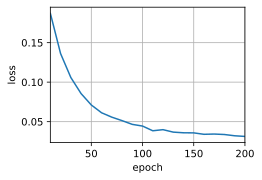

In [35]:
# 训练
myutils.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [36]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = myutils.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ', f'bleu {myutils.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => je suis <unk> .,  bleu 0.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


![jupyter](img/bleu-def.PNG)

![jupyter](img/bleu.PNG)

# Visualization of Attention Weights
# 可视化最后一个句子的注意力权重矩阵

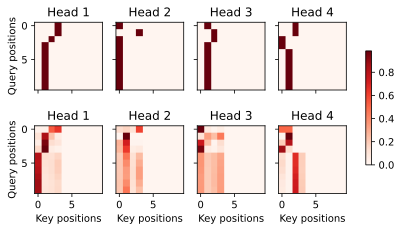

In [37]:
# encoder 部分的注意力权重
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
-1, num_steps))

myutils.show_heatmaps(
enc_attention_weights.cpu(), xlabel='Key positions',
ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
figsize=(7, 3.5))

In [38]:
# decoder 部分的注意力权重
dec_attention_weights_2d = [head[0].tolist() for step in dec_attention_weight_seq for attn in step for blk in attn for head in blk]

dec_attention_weights_filled = torch.tensor(
        pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

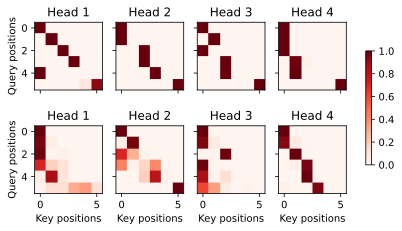

In [39]:
# decoder 的自注意力权重
myutils.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

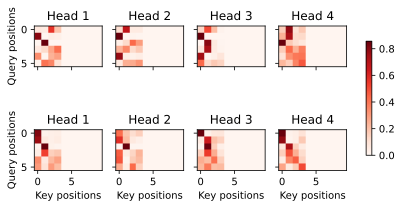

In [40]:
# decoder 与 encoder 部分的注意力权重
myutils.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))